In [236]:
### airfare_visitor lead_time 7 average & moving average 

In [237]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot

from google.cloud import bigquery

In [238]:
bqclient = bigquery.Client(project='charged-genre-350106')

In [239]:
query_visitor= """
SELECT
  A.DT,SUM(A.PCOUNT)
FROM (
  SELECT
    CONCAT(SUBSTR(CAST(DT AS string),0,4), SUBSTR(CAST(DT AS string),6,2), SUBSTR(CAST(DT AS string), 9,2)) AS DT,
    ARRIVE_PPL AS PCOUNT
  FROM
    `charged-genre-350106.kaflix.AIRLINE_PASSENGER`) AS A
GROUP BY
  A.DT
ORDER BY DT DESC
"""

In [240]:
query_airfare = """
    WITH MAIN AS (
        SELECT *
        FROM kaflix.AIRLINE_TICKET A
        WHERE 1=1
            -- AND A.DEPART = 'GMP'
            -- AND A.ARRIVE = 'CJU'
        AND A.SEARCH_DATE NOT IN ('2022-07-08', '2022-07-09', '2022-07-10',  '2022-07-12')
    )
    SELECT
        A.*
    FROM(
        SELECT
           CONCAT(CAST(FORMAT_DATE("%E4Y", CAST(LEFT(DEPART_DATE,10) as date)) AS string),
                  CAST(FORMAT_DATE("%m", CAST(LEFT(DEPART_DATE,10) as date)) AS string),
                  CAST(FORMAT_DATE("%d", CAST(LEFT(DEPART_DATE,10) as date)) AS string)) AS DEPART_DT
           , CONCAT(CAST(FORMAT_DATE("%E4Y", CAST(LEFT(SEARCH_DATE, 10) as date)) AS string),
                    CAST(FORMAT_DATE("%m", CAST(LEFT(SEARCH_DATE,10) as date)) AS string),
                    CAST(FORMAT_DATE("%d", CAST(LEFT(SEARCH_DATE,10) as date)) AS string)) AS SEARCH_DT
           , DATE_DIFF(CAST(LEFT(DEPART_DATE,10) AS date), CAST(LEFT(SEARCH_DATE,10) as date), DAY) AS LEAD_TM
        , ROUND(AVG(FARE),0) AS FARE_AVG
        FROM MAIN
        WHERE 1=1
        GROUP BY 
        DEPART_DATE, SEARCH_DATE
    ) A
    ORDER BY 
      A.DEPART_DT DESC
      , A.LEAD_TM
    """

In [241]:
#today & day6beore
today = date.today()
day7before = date.today() - timedelta(7)
day7before = day7before.strftime('%Y-%m-%d')

### 과거 - 입도객 데이터

In [242]:
#입도객 데이터 로드
vst = bqclient.query(query_visitor).to_dataframe()

#컬럼명 변경
vst.columns=['date','visitor']

#datetype 변경
vst['date']=pd.to_datetime(vst['date'])

#날짜순서대로 정렬
vst=vst.sort_values(by='date')

#이동평균 컬럼
vst['visitor_7ma']=vst['visitor'].rolling(window=7).mean().round(0)

### 과걱 - 항공권 데이터

In [243]:
#항공권 데이터 로드
af = bqclient.query(query_airfare).to_dataframe()

#컬럼명 변경
af.columns=['date','search_dt','lead_tm','fare_avg']

#datatype 변경
af['date']=pd.to_datetime(af['date'])
af['search_dt']=pd.to_datetime(af['search_dt'])

#lead_tm 1부터 7까지 
af=af.query("1<=lead_tm <= 7")

#날짜순서대로 변경
af=af.sort_values(by='date')

#필요한 컬럼만 선택
af=af[['date','fare_avg']]

#항공권가격 일별 평균
af=af.groupby('date').agg(['mean']).round(0).reset_index()

#멀티컬럼인덱스 flatten
af.columns = af.columns.to_flat_index().map(lambda x: x[0])

#이동평균 컬럼
af['fare_avg_7ma']=af['fare_avg'].rolling(window=7).mean().round(0)

### 과거 - 데이터 연계

In [244]:
merge_af_vst=af.merge(vst, how='left', on='date')
merge_af_vst.sort_values(by='date')

,date,fare_avg,fare_avg_7ma,visitor,visitor_7ma
0,2021-07-01,61732.0,NaN,40443.0,41150.0
1,2021-07-02,72038.0,NaN,38961.0,40286.0
2,2021-07-03,68250.0,NaN,35043.0,39142.0
3,2021-07-04,61359.0,NaN,37367.0,38109.0
4,2021-07-05,58044.0,NaN,37135.0,37492.0
...,...,...,...,...,...
456,2022-09-30,83198.0,71388.0,NaN,NaN
457,2022-10-01,83874.0,71499.0,NaN,NaN
458,2022-10-02,81592.0,71718.0,NaN,NaN
459,2022-10-03,76189.0,72980.0,NaN,NaN


In [245]:
#필요한 컬럼만 선택
merge_af_vst=merge_af_vst[['date','fare_avg_7ma','visitor_7ma']]

### 미래 - 항공권 데이터

In [246]:
#항공권 데이터 로드
af_future = bqclient.query(query_airfare).to_dataframe()

#컬럼명 변경
af_future.columns=['date','search_dt','lead_tm','fare_avg']

#datatype 변경
af_future['date']=pd.to_datetime(af_future['date'])
af_future['search_dt']=pd.to_datetime(af_future['search_dt'])

#7일전 데이터부터 
af_future=af_future[af_future['search_dt'] >= day7before].sort_values(by='date')

#필요한 컬럼만 선택
af_future=af_future[['date','fare_avg']]

#항공권가격 일별 평균
af_future=af_future.groupby('date').agg(['mean']).round(0).reset_index()

#멀티컬럼인덱스 flatten
af_future.columns = af_future.columns.to_flat_index().map(lambda x: x[0])

#이동평균 컬럼
af_future['fare_avg_7ma']=af_future['fare_avg'].rolling(window=7).mean().round(0)

#필요한 컬럼 선택
af_future=af_future[['date','fare_avg_7ma']]


### 과거 - 미래 데이터 연계

In [247]:
airfare_visitor=pd.concat([merge_af_vst,af_future], axis=0)
airfare_visitor

,date,fare_avg_7ma,visitor_7ma
0,2021-07-01,NaN,41150.0
1,2021-07-02,NaN,40286.0
2,2021-07-03,NaN,39142.0
3,2021-07-04,NaN,38109.0
4,2021-07-05,NaN,37492.0
...,...,...,...
62,2022-11-22,68923.0,NaN
63,2022-11-23,68714.0,NaN
64,2022-11-24,68856.0,NaN
65,2022-11-25,68675.0,NaN


### 시각화

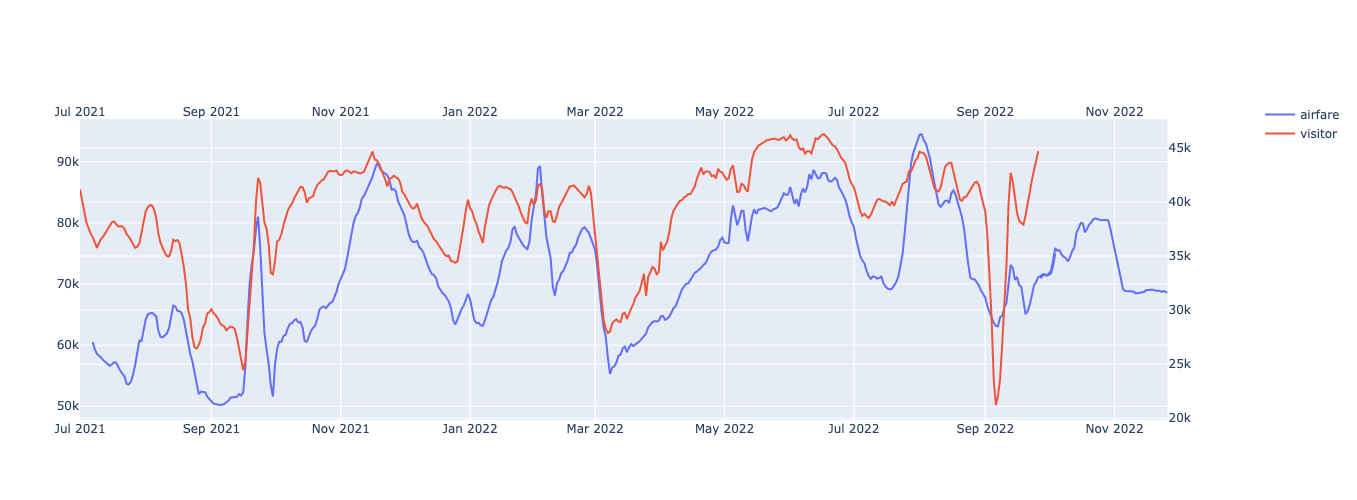

'airfare_visitor.html'

In [248]:
fig=make_subplots(
        specs=[[{"secondary_y": True}]])   

fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
                  yaxis_domain=[0, 0.94]);

fig.add_trace(
    go.Scatter(x=airfare_visitor['date'], y=airfare_visitor['fare_avg_7ma'], name="airfare"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=airfare_visitor['date'], y=airfare_visitor['visitor_7ma'], name="visitor"),
    secondary_y=True
)

fig.data[1].update(xaxis='x2')
fig.update_layout(width=2200, height=500)


fig.show()

# fig.show()
plot(fig, filename='airfare_visitor.html')